In [1]:
import random

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import openpyxl
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow

In [2]:
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
# Location of the dataset
# Path for Ravdess dataset
ravdess_train_directory = "datasets/train/RavdevsLow"
ravdess_test_directory = "datasets/test/RavdevsLow"
# Path for Savee dataset
savee_train_directory = "datasets/train/Savee"
savee_test_directory = "datasets/test/Savee"
# Path for Tess dataset
tess_train_directory = "datasets/train/TESS"
tess_test_directory = "datasets/test/TESS"
# Path for CREMA-D dataset
cremaD_train_directory = "datasets/train/CremaD"
cremaD_test_directory = "datasets/test/CremaD"
# Path for EVOV-DB
emoDB_train_directory = "datasets/train/EMODB"
# Path for JL
jl = "datasets/train/JL"
# Path for JL2
jl2 = "datasets/train/JL2"
# Path for IEMOCAP
iemocap = "datasets/train/IEMOCAP"
# Path for ML-END
mlEnd = "datasets/train/MLEnd"

In [4]:
def getRavdessDataframe(ravdess):
    ravdess_directory_list = os.listdir(ravdess)
    file_emotion = []
    file_path = []
    for file in ravdess_directory_list:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + "/" + file)

    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
    # Happy and surprise merged, 8 was initially surprise
    #
    # changing integers to actual emotions.
    Ravdess_df.Emotions.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad',
                                 5: 'angry', 6: 'sad', 7: 'angry', 8: 'happy'}, inplace=True)
    return Ravdess_df


def getCremaDataframe(cremaD):
    crema_directory_list = os.listdir(cremaD)
    file_emotion = []
    file_path = []

    for file in crema_directory_list:
        # storing file paths
        file_path.append(cremaD + "/" + file)
        # storing file emotions
        part = file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'FEA':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('angry')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Crema_df = pd.concat([emotion_df, path_df], axis=1)
    return Crema_df


def getTessDataframe(tess):
    tess_directory_list = os.listdir(tess)
    file_emotion = []
    file_path = []

    for dir in tess_directory_list:
        directories = os.listdir(tess + "/" + dir)
        for file in directories:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part == 'ps':
                file_emotion.append('happy')
            elif part == "disgust":
                file_emotion.append("angry")
            elif part == "fear":
                file_emotion.append("sad")
            else:
                file_emotion.append(part)
            file_path.append(tess + "/" + dir + '/' + file)

    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Tess_df = pd.concat([emotion_df, path_df], axis=1)
    return Tess_df


def getSaveeDataframe(savee):
    savee_directory_list = os.listdir(savee)

    file_emotion = []
    file_path = []

    for file in savee_directory_list:
        file_path.append(savee + "/" + file)
        part = file.split('_')[1]
        ele = part[:-6]
        if ele == 'a':
            file_emotion.append('angry')
        elif ele == 'd':
            file_emotion.append('angry')
        elif ele == 'f':
            file_emotion.append('sad')
        elif ele == 'h':
            file_emotion.append('happy')
        elif ele == 'n':
            file_emotion.append('neutral')
        elif ele == 'sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('happy')

    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Savee_df = pd.concat([emotion_df, path_df], axis=1)
    return Savee_df


def getEmoDataframe(emoDB):
    emoDb_directory_list = os.listdir(emoDB)
    file_emotion = []
    file_path = []

    for dir in emoDb_directory_list:
        parentFolder = emoDB + "/" + dir
        actorsList = os.listdir(parentFolder)
        for folders in actorsList:
            childFolder = parentFolder + "/" + folders
            files = os.listdir(childFolder)
            for item in files:
                part = item.split("_")
                if part[0].lower() == "anger":
                    file_emotion.append("angry")
                elif part[0].lower() == "amused":
                    file_emotion.append("surprise")
                else:
                    file_emotion.append(part[0].lower())
                # file_emotion.append(part[0])
                file_path.append(childFolder + "/" + item)

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    emoDB_df = pd.concat([emotion_df, path_df], axis=1)
    return emoDB_df


In [5]:
def getEmotionsCount(dataframeToCount):
    emotionCount = {}
    for i in dataframeToCount.index:
        emotions = dataframeToCount["Emotions"][i]
        if emotions in emotionCount:
            emotionCount[emotions] += 1
        else:
            emotionCount[emotions] = 1
    emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
    print(emotionCount)

In [6]:
def getEmotionsAfterUnderSampling(dataframeToUnderSample):
    # smallCount = min(emotionCount.values())
    counts = dataframeToUnderSample['Emotions'].value_counts()
    # find the minimum count
    min_count = counts.min()
    # create a list to store the balanced dataframes
    balanced_dfs = []
    # iterate over the emotions
    for emotion in counts.index:
        # subset the data for the current emotion to have the minimum count
        balanced_df = dataframeToUnderSample[dataframeToUnderSample['Emotions'] == emotion].head(min_count)
        balanced_dfs.append(balanced_df)
    # concatenate all the balanced dataframes into one final dataframe
    final_df = pd.concat(balanced_dfs)
    return final_df

In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


In [8]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


def volumeAdd(data):
    songData = AudioSegment.from_wav(data)
    print("sing", songData)
    songDataSamples = np.array(songData.get_array_of_samples())
    songHighVolumed = songDataSamples - 10000.0
    print(songHighVolumed)
    return songHighVolumed


In [9]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically

    return result


In [10]:
# trainingDF
ravdess_train_df = getRavdessDataframe(ravdess_train_directory)
crema_train_df = getCremaDataframe(cremaD_train_directory)
tess_train_df = getTessDataframe(tess_train_directory)
savee_train_df = getSaveeDataframe(savee_train_directory)
emo_train_df = getEmoDataframe(emoDB_train_directory)

# Testing df
ravdess_test_df = getRavdessDataframe(ravdess_test_directory)
crema_test_df = getCremaDataframe(cremaD_test_directory)
tess_test_df = getTessDataframe(tess_test_directory)
savee_test_df = getSaveeDataframe(savee_test_directory)

In [11]:
getEmotionsCount(ravdess_train_df)
getEmotionsCount(ravdess_test_df)

{'angry': 277, 'happy': 260, 'neutral': 194, 'sad': 276}
{'angry': 54, 'happy': 68, 'neutral': 47, 'sad': 48}


In [12]:
ravdess_train_df = getEmotionsAfterUnderSampling(ravdess_train_df)
ravdess_train_df.head()

,Emotions,Path
461,angry,datasets/train/RavdevsLow/03-01-05-01-01-01-02...
462,angry,datasets/train/RavdevsLow/03-01-05-01-01-01-03...
463,angry,datasets/train/RavdevsLow/03-01-05-01-01-01-04...
464,angry,datasets/train/RavdevsLow/03-01-05-01-01-01-06...
465,angry,datasets/train/RavdevsLow/03-01-05-01-01-01-07...


In [13]:
getEmotionsCount(ravdess_train_df)

{'angry': 194, 'happy': 194, 'neutral': 194, 'sad': 194}


In [14]:
getEmotionsCount(crema_train_df)

{'angry': 1768, 'happy': 907, 'neutral': 781, 'sad': 1753}


In [15]:
crema_train_df = getEmotionsAfterUnderSampling(crema_train_df)
crema_train_df.head()

,Emotions,Path
0,angry,datasets/train/CremaD/1001_DFA_ANG_XX.wav
1,angry,datasets/train/CremaD/1001_DFA_DIS_XX.wav
4,angry,datasets/train/CremaD/1001_IEO_ANG_HI.wav
5,angry,datasets/train/CremaD/1001_IEO_ANG_LO.wav
6,angry,datasets/train/CremaD/1001_IEO_ANG_MD.wav


In [16]:
getEmotionsCount(crema_train_df)

{'angry': 781, 'happy': 781, 'neutral': 781, 'sad': 781}


In [17]:
getEmotionsCount(tess_train_df)
tess_train_df = pd.concat([tess_train_df,emo_train_df], ignore_index=True)
getEmotionsCount(tess_train_df)

{'angry': 560, 'happy': 560, 'neutral': 280, 'sad': 560}
{'angry': 560, 'happy': 560, 'neutral': 637, 'sad': 560}


In [18]:
tess_train_df = getEmotionsAfterUnderSampling(tess_train_df)
tess_train_df.head()

,Emotions,Path
1120,neutral,datasets/train/TESS/neutral/OAF_back_neutral.wav
1121,neutral,datasets/train/TESS/neutral/OAF_bar_neutral.wav
1122,neutral,datasets/train/TESS/neutral/OAF_bath_neutral.wav
1123,neutral,datasets/train/TESS/neutral/OAF_bean_neutral.wav
1124,neutral,datasets/train/TESS/neutral/OAF_beg_neutral.wav


In [19]:
getEmotionsCount(tess_train_df)

{'angry': 560, 'happy': 560, 'neutral': 560, 'sad': 560}


In [20]:
getEmotionsCount(savee_train_df)

{'angry': 90, 'happy': 74, 'neutral': 86, 'sad': 86}


In [21]:
savee_train_df = getEmotionsAfterUnderSampling(savee_train_df)
savee_train_df.head()

,Emotions,Path
0,angry,datasets/train/Savee/DC_a01.wav
1,angry,datasets/train/Savee/DC_a02.wav
2,angry,datasets/train/Savee/DC_a03.wav
3,angry,datasets/train/Savee/DC_a05.wav
4,angry,datasets/train/Savee/DC_a06.wav


In [22]:
getEmotionsCount(savee_train_df)

{'angry': 74, 'happy': 74, 'neutral': 74, 'sad': 74}


In [23]:
# data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df,emoDB_df, jl_df, jl2_df, iemocap_df], axis = 0)
# data_path = pd.concat([Crema_df, Tess_df, Savee_df], axis=0)
# data_path = pd.concat([Savee_df], axis=0)
data_path_train = pd.concat([ravdess_train_df, crema_train_df, tess_train_df, savee_train_df], axis=0)
data_path_test = pd.concat([ravdess_test_df, crema_test_df, tess_test_df, savee_test_df], axis=0)
data_path_train.to_csv("data_path_EmotionsCombined_Training.csv", index=False)
data_path_test.to_csv("data_path_EmotionsCombined_Testing.csv", index=False)
data_path_train.head()

,Emotions,Path
461,angry,datasets/train/RavdevsLow/03-01-05-01-01-01-02...
462,angry,datasets/train/RavdevsLow/03-01-05-01-01-01-03...
463,angry,datasets/train/RavdevsLow/03-01-05-01-01-01-04...
464,angry,datasets/train/RavdevsLow/03-01-05-01-01-01-06...
465,angry,datasets/train/RavdevsLow/03-01-05-01-01-01-07...


In [24]:
emotionList = pd.read_csv("data_path_EmotionsCombined_Training.csv")
emotions = emotionList["Emotions"]
emotionCount = {}
for item in emotions:
    if item in emotionCount:
        emotionCount[item] += 1
    else:
        emotionCount[item] = 1
emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
print(emotionCount)

{'angry': 1609, 'happy': 1609, 'neutral': 1609, 'sad': 1609}


['angry', 'happy', 'neutral', 'sad']

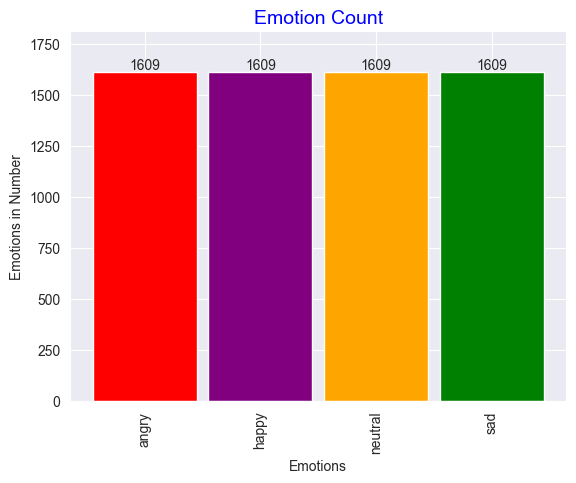

In [25]:
plt.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
        color=["red", "purple", "orange", "green", "cyan", "blue", "yellow"])
plt.xlabel("Emotions")
plt.xticks(rotation=90)
plt.ylabel("Emotions in Number")
plt.title("Emotion Count", size=14, color="Blue")
plt.ylim([0, max(emotionCount.values()) + 200])
lst = []
for item in emotionCount:
    plt.text(item, emotionCount[item],
             emotionCount[item], ha="center", va="bottom")
sorted(emotionCount)


datasets/train/RavdevsLow/03-01-05-01-01-01-03.wav


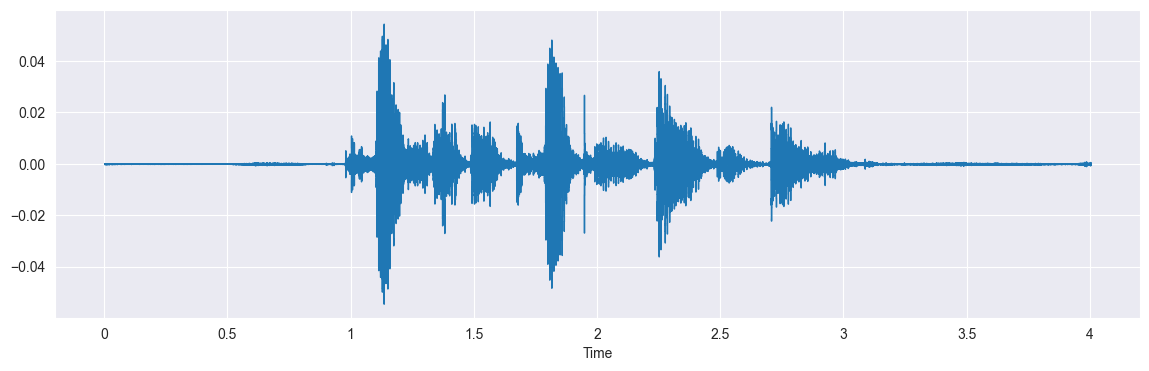

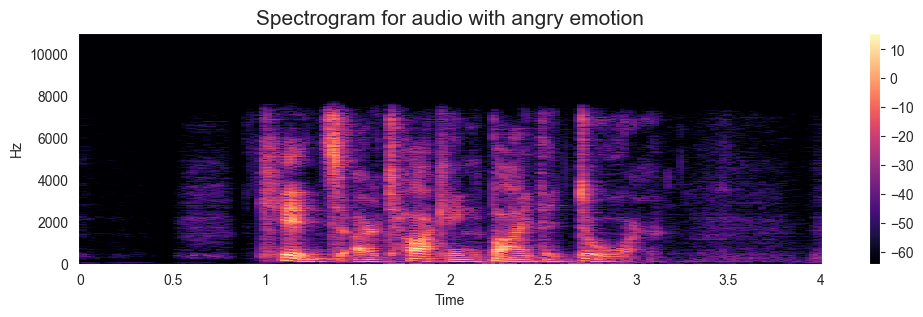

In [26]:
# taking any example and checking for techniques.
path = np.array(data_path_train.Path)[1]
print(path)
data, sample_rate = librosa.load(path)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)
create_spectrogram(data, sample_rate, np.array(data_path_train.Emotions)[1])

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path_train.Path, data_path_train.Emotions):
    try:
        feature = get_features(path)
    except:
        print(path)
        print(emotion)
    for ele in feature:
        try:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        except:
            print(ele)


X_test, Y_test = [], []
for path, emotion in zip(data_path_test.Path, data_path_test.Emotions):
    try:
        feature = get_features(path)
    except:
        print(path)
        print(emotion)
    for ele in feature:
        try:
            X_test.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y_test.append(emotion)
        except:
            print(ele)

In [ ]:
len(X), len(Y), data_path_train.Path.shape
len(X_test), len(Y_test), data_path_test.Path.shape

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_excel('features_EmotionsCombined_Training.xlsx', index=False)
Features.head()

Features_test = pd.DataFrame(X_test)
Features_test['labels'] = Y_test
Features_test.to_excel('features_EmotionsCombined_Testing.xlsx', index=False)
Features_test.head()


In [ ]:
x_train = Features.iloc[:, :-1].values
y_train = Features['labels'].values
x_test = Features_test.iloc[:, :-1].values
y_test = Features_test['labels'].values

In [ ]:
features_train_df = pd.read_excel("features_EmotionsCombined_Training.xlsx")
features_test_df = pd.read_excel("features_EmotionsCombined_Testing.xlsx")

In [ ]:
featuresofit = np.asarray(features_train_df.iloc[:, :-1].values)
x_train = featuresofit
labelofit = np.asarray(features_train_df['labels'])
y_train = labelofit

featuresofit_test = np.asarray(features_test_df.iloc[:, :-1].values)
x_test = featuresofit_test
labelofit_test = np.asarray(features_test_df['labels'])
y_test = labelofit_test

In [ ]:
len(x_test), len(x_train)

In [ ]:
emotionsfromFeatures = features_train_df['labels']
emotionCountfromFeatures = {}
for item in emotionsfromFeatures:
    if item in emotionCountfromFeatures:
        emotionCountfromFeatures[item] += 1
    else:
        emotionCountfromFeatures[item] = 1
print(emotionCountfromFeatures)

In [ ]:
fig, (plt1, plt2) = plt.subplots(1, 2, sharey=True, figsize=(12, 3))
plt1.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
         color=["red", "purple", "orange", "green", "cyan", "blue", "yellow"])
plt1.set_xlabel("Emotions")
plt1.set_ylabel("Emotions in Number")
plt1.set_title("Emotion Count", size=14, color="Blue")
plt1.set_ylim([0, max(emotionCount.values()) + 200])
# lst = []
for item in emotionCount:
    plt1.text(item, emotionCount[item],
              emotionCount[item], ha="center", va="bottom")

plt2.bar(emotionCountfromFeatures.keys(), emotionCountfromFeatures.values(), width=0.9, align="center",
         color=["red", "purple", "orange", "green", "cyan", "blue", "yellow"])
plt2.set_xlabel("Emotions from Features")
plt2.set_ylabel("Emotions from features in Number")
plt2.set_title("Emotion Count from Features", size=14, color="Blue")
plt2.set_ylim([0, max(emotionCountfromFeatures.values()) + 200])
# lst = []
for item in emotionCountfromFeatures:
    plt2.text(item, emotionCountfromFeatures[item],
              emotionCountfromFeatures[item], ha="center", va="bottom")
# plt2.subplots(nrows=1,ncols=2)

In [ ]:
# print(Y)
# x_train, x_test, y_train, y_test = train_test_split(
#     X, Y, random_state=0, test_size=0.1, shuffle=True)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape
# # pd.DataFrame(Y)

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# x_train = pca.fit_transform(x_train)
# x_test = pca.fit_transform(x_test)

In [ ]:
# C_choice = [150,200,250,300,350]
# C_choice = [0.5, 0.6, 0.8, 0.9, 1]


In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

classifier = svm.SVC(kernel='linear', gamma="auto", C=1000)
classifier.fit(x_train, y_train)
y_predict = classifier.predict(x_test)
accuracyPercent = accuracy_score(y_test, y_predict) * 100
print("Kernel:  " + "linear" + "  ||  " + " C: " + str(1) + "  ||  Accuracy" + "  :  " + str(accuracyPercent))

In [ ]:
y_predict_train = classifier.predict(x_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_predict_train)))

In [ ]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


confusion = confusion_matrix(y_test, y_predict)
# df_confusion = pd.crosstab(y_test, y_predict, rownames=['True'], colnames=['Predicted'], margins=True)

plot_confusion_matrix(confusion, classes=["angry", "sad", "neutral", "happy"],
                      title='Confusion Matrix')
plt.show()


In [ ]:
print(classification_report(y_test, y_predict))

In [ ]:
# import joblib
# joblib.dump(classifier, "audio_svm_model_4DS.joblib")

In [ ]:
# from joblib import dump
# dump(scaler, 'scaler.joblib')